In [3]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [4]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [5]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 1. Read the data

In [6]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import Dataset, DataLoader

In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [9]:
print(f'The shape of training data is {train_data.shape}\nThe shape of testing data is {test_data.shape}')

The shape of training data is (1460, 81)
The shape of testing data is (1459, 80)


In [10]:
# visualize some of the data and their features
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [11]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 2. Data Preprocessing

In [12]:
# replace all the numeric nan value with feature mean and do standardization
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean())/ (x.std()))

all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [13]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [14]:
# get dummies increase the number of features to 331
all_features.columns.unique()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=331)

## 3. Training

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [16]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[: n_train].values, dtype = torch.float32, device=device)
test_features = torch.tensor(all_features[n_train: ].values, dtype = torch.float32, device=device)
train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype = torch.float32, device=device
)

In [17]:
# get the data
batch_size = 64
class Train(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label
    
    def __len__(self):
        return len(self.features)

In [18]:
loss = nn.MSELoss()
# Define the loss function
def log_rmse(preds, y):
    clipped_preds = torch.clamp(preds, 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(y)))
    return rmse

In [19]:
def train(num_epochs, net, train_features, train_labels, test_features, test_labels, batch_size, loss, optimizer, silent = True):
    train_ls, test_ls = [], []
    # get the training data iterator
    train_iter = DataLoader(Train(train_features, train_labels), batch_size=batch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            l = loss(net(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net(train_features), train_labels).item())
        if test_labels is not None:
            test_ls.append(log_rmse(net(test_features), test_labels).item())

        if not silent:
            if (epoch + 1) % 100 == 0:
                print(f'After {epoch + 1} epochs, the log rmse is {train_ls[-1]}')
    
    return train_ls, test_ls

In [20]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, num_epochs, X_train, y_train, batch_size, loss, lr, wd, initialize = (None, None)):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        net = get_net(*initialize).to(device)
        optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=wd)
        data = get_k_fold_data(k, i, X_train, y_train) 
        train_ls, valid_ls = train(num_epochs, net, *data, batch_size, loss, optimizer)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        print(f'Fold {i + 1}, training log rmse {float(train_ls[-1]):f}, '
              f'validating log rmse {float(valid_ls[-1]):f}')

    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
            xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
            legend=['train', 'valid'], yscale='log')
    
    return train_l_sum / k, valid_l_sum / k

In [21]:
# Define the number of folds
k = 5
# Define the number of epochs to train
num_epochs = 1000
# Define the batch size
batch_size = 256

In [22]:
# Define a simple linear model
in_features = train_features.shape[1]
# in every k-fold we need a new model so we cannot use net as a parameter of the function

def get_net(mean = None, std = None):
    net = nn.Sequential(nn.Linear(in_features, 1))
    if mean != None and std != None:
        torch.nn.init.normal_(net[0].weight, mean, std)
    return net

In [23]:
# pre-train a model to help initialization
net_test = get_net().to(device)
optimizer = torch.optim.Adam(params=net_test.parameters(), lr=5, weight_decay=0)
_, _ = train(300, net_test, train_features, train_labels, None, None, 128, loss, optimizer)
w_mean = net_test[0].weight.mean()
w_std = net_test[0].weight.std()
print(f'Mean of weights is {w_mean}\nStd of weights is {w_std}')

Mean of weights is 2972.83203125
Std of weights is 2528.5078125


In [24]:
# Define the optimizer
wd = 0
lr = 5

Fold 1, training log rmse 0.113106, validating log rmse 0.136619
Fold 2, training log rmse 0.109165, validating log rmse 0.145110
Fold 3, training log rmse 0.109110, validating log rmse 0.140290
Fold 4, training log rmse 0.114526, validating log rmse 0.120733
Fold 5, training log rmse 0.104622, validating log rmse 0.154083


(0.11010605096817017, 0.13936721980571748)

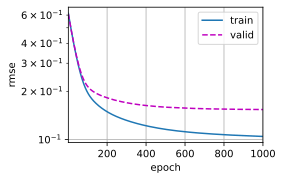

In [25]:
k_fold(k, num_epochs, train_features, train_labels, batch_size, log_rmse, lr, wd, initialize=(w_mean.item(), w_std.item()))

## 4. More complex neural networks

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, \
                       dropout1, dropout2):
        super().__init__()
        self.num_inputs = num_inputs
        self.lin_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, num_hidden1),
            nn.ReLU(),
            nn.Dropout(dropout1),
            nn.Linear(num_hidden1, num_hidden2),
            nn.ReLU(),
            nn.Linear(num_hidden2, num_hidden3),
            nn.ReLU(), 
            nn.Dropout(dropout2), 
            nn.Linear(num_hidden3, num_hidden4),
            nn.ReLU(),
            nn.Linear(num_hidden4, num_hidden5),
            nn.ReLU(),
            nn.Linear(num_hidden5, num_outputs)
        )
        self.num_layers = len(self.lin_relu_stack)
    
    def forward(self, X):
        out = self.lin_relu_stack(X)

        return out

    def __getitem__(self, idx):
        return self.lin_relu_stack[idx]

num_inputs, num_outputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, \
    dropout1, dropout2 = train_features.shape[1], 1, 256, 128, 64, 32, 16, 0.1, 0.1

def get_net(mean = None, std = None):  
    net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, dropout1, dropout2)

    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
    
    if mean == None and std == None:
        net.apply(init_weights)
    return net

Fold 1, training log rmse 0.117262, validating log rmse 0.149722
Fold 2, training log rmse 0.105228, validating log rmse 0.160062
Fold 3, training log rmse 0.122502, validating log rmse 0.173986
Fold 4, training log rmse 0.109207, validating log rmse 0.154571
Fold 5, training log rmse 0.098646, validating log rmse 0.167645


(0.1105689600110054, 0.16119738221168517)

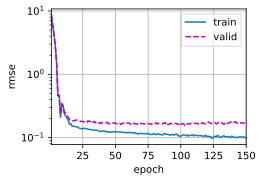

In [27]:
lr = 0.005
wd = 1
k_fold(k, 150, train_features, train_labels, batch_size, loss, lr, wd=0)

In [28]:
net_test = get_net().to(device)
optimizer = torch.optim.Adam(net_test.parameters(), lr = lr)
_, _ = train(1000, net_test, train_features, train_labels, None, None, batch_size, loss, optimizer, False)

After 100 epochs, the log rmse is 0.119967982172966
After 200 epochs, the log rmse is 0.08969400078058243
After 300 epochs, the log rmse is 0.09322861582040787
After 400 epochs, the log rmse is 0.07431600987911224
After 500 epochs, the log rmse is 0.06346986442804337
After 600 epochs, the log rmse is 0.05255095660686493
After 700 epochs, the log rmse is 0.04799976944923401
After 800 epochs, the log rmse is 0.04507290944457054
After 900 epochs, the log rmse is 0.04499027132987976
After 1000 epochs, the log rmse is 0.04084409773349762


In [29]:
net_test[0].weight

Parameter containing:
tensor([[ 0.0038, -0.2070,  0.2505,  ...,  0.1610,  0.1150, -0.0298],
        [-0.0189, -0.0258,  0.1134,  ...,  0.1659,  0.0068, -0.0529],
        [ 0.0030, -0.0813,  0.1473,  ...,  0.1589,  0.1183,  0.1122],
        ...,
        [-0.4433,  0.1095,  0.1359,  ...,  0.2540, -0.0964, -0.0547],
        [-0.2037,  0.0120,  0.0725,  ...,  0.1524,  0.0716, -0.0144],
        [-0.6446, -0.0421,  0.2032,  ...,  0.0861, -0.3713, -0.0142]],
       device='cuda:0', requires_grad=True)

In [30]:
net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2).to(device)
for i in range(net.num_layers):
    m = net[i]
    if type(m) == nn.Linear:
        m.weight = net_test[i].weight
        m.bias = net_test[i].bias

TypeError: __init__() missing 5 required positional arguments: 'num_hidden3', 'num_hidden4', 'num_hidden5', 'dropout1', and 'dropout2'

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = 1e-5)
train(1000, net, train_features, train_labels, None, None, batch_size, log_rmse, optimizer, False)

After 100 epochs, the log rmse is 0.09976816922426224
After 200 epochs, the log rmse is 0.09420372545719147
After 300 epochs, the log rmse is 0.09313063323497772
After 400 epochs, the log rmse is 0.09109007567167282
After 500 epochs, the log rmse is 0.08917190134525299
After 600 epochs, the log rmse is 0.08837396651506424
After 700 epochs, the log rmse is 0.08584323525428772
After 800 epochs, the log rmse is 0.08496735244989395
After 900 epochs, the log rmse is 0.08208217471837997
After 1000 epochs, the log rmse is 0.08101148903369904


([0.10522351413965225,
  0.10584581643342972,
  0.10513126105070114,
  0.10364477336406708,
  0.10252813249826431,
  0.10209473222494125,
  0.1021905317902565,
  0.10145218670368195,
  0.10135582834482193,
  0.10182589292526245,
  0.1024826243519783,
  0.10094781219959259,
  0.10109126567840576,
  0.10165366530418396,
  0.10054995864629745,
  0.10050839930772781,
  0.10017622262239456,
  0.10060519725084305,
  0.10002367198467255,
  0.10002076625823975,
  0.10027268528938293,
  0.10014091432094574,
  0.09992079436779022,
  0.09972219914197922,
  0.09976007044315338,
  0.09992741048336029,
  0.09942423552274704,
  0.10043425112962723,
  0.09971901774406433,
  0.10054417699575424,
  0.10136701166629791,
  0.09922132641077042,
  0.1012645959854126,
  0.09971778839826584,
  0.09974101185798645,
  0.10146428644657135,
  0.09909635037183762,
  0.10131382942199707,
  0.10032086074352264,
  0.10001085698604584,
  0.09921742230653763,
  0.10019995272159576,
  0.0989358127117157,
  0.09904571622

## Train and predict

In [ ]:
num_epochs = 300
net = NeuralNetwork(num_inputs, num_outputs, num_hidden1, num_hidden2).to(device)
batch_size = 256

lr = 0.01
wd = 2
optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = wd)

In [ ]:
train_loss, _ = train(num_epochs, net, train_features, train_labels, None, None, batch_size, loss, optimizer, False)

After 100 epochs, the log rmse is 0.10975059866905212
After 200 epochs, the log rmse is 0.08551531285047531
After 300 epochs, the log rmse is 0.06319578737020493


In [ ]:
def pred(net, test_features, test_data):
    result = net(test_features).detach()
    if device != 'cpu':
        result = result.cpu()
    test_data['SalePrice'] = result.numpy()
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

# pred(net, test_features, test_data)

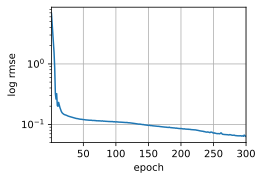

In [ ]:
d2l.plot(np.arange(1, num_epochs + 1), [train_loss], xlabel='epoch',
            ylabel='log rmse', xlim=[1, num_epochs], yscale='log')